# Statistical Measurements and Visualizations

In this recitation, we are going to discuss and compare some of the statistical measurements from a practical point of view. To this end, we are going to utilize multiple datasets, in addition to synthetic distributions.

In [1]:
# import google
# from google.colab import drive
# drive.mount("./drive", force_remount=True)

# path_prefix = "./drive/My Drive"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

## Descriptive vs Inferential Statistics

![](https://s3.amazonaws.com/libapps/accounts/73970/images/descriptive_and_inferential.JPG)

## Data Levels of Measurement

> A variable has one of four different levels of measurement.

![](https://lh5.googleusercontent.com/7jyxzQ2ObysJGLFcGB6Zc25AHAswexk68SbOh_KYa4if2P9yRe7lIC8NDUgZEcSGspqpRIGQcMx_qCmrG6sjHegFHy9Sqhp_1z3PFido6d19TKYFq0pMTHDs4OV9l6pP-MTNmeKu)



Explanations and examples of these level of measurements can also be found below.

![](https://sixsigmastats.com/wp-content/uploads/2019/07/scale.png)

In this notebook, we are going to scrape a table from this [link](https://www.theyshootpictures.com/gf1000_all1000films_table.php) and store it as a dataframe.

![](https://i.ibb.co/j4VcfNf/ts.png)

In [3]:
from bs4 import BeautifulSoup
import requests

In [4]:
# url that stores the required table
url = "https://www.theyshootpictures.com/gf1000_all1000films_table.php"

# retrieve the html document
res = requests.get(url)
res.status_code

200

In [5]:
# get the raw html text
content = res.text
# parse and store the domtree
# with beautifulsoup
soup = BeautifulSoup(content,"html.parser")

In [6]:
# get the column names
header = soup.find("thead").findAll("th")
column_names = [entry.text for entry in header]
column_names

['\ufeffPos', '2022', 'Title', 'Director', 'Year', 'Country', 'Mins']

In [7]:
# find the table in the document
table = soup.find("tbody")
rows = []
for entry in table.findAll("tr"):
  # merge column names and zip them with the values
  row = dict(zip(column_names, [value.text for value in entry.findAll("td")]))
  rows.append(row)
df = pd.DataFrame(rows)
df.head()

,﻿Pos,2022,Title,Director,Year,Country,Mins
0,1,1,Citizen Kane,"Welles, Orson",1941,USA,119
1,2,2,Vertigo,"Hitchcock, Alfred",1958,USA,128
2,3,3,2001: A Space Odyssey,"Kubrick, Stanley",1968,UK,139
3,4,5,Tokyo Story,"Ozu, Yasujiro",1953,Japan,134
4,5,4,"Rules of the Game, The","Renoir, Jean",1939,France,113


Some of the movie names are problematic in the table, such that they end with `, the` postfix  
whereas the title should have begun as `The ...`

Now let's fix this problem.

In [8]:
def fix_title(title):
  if title.endswith(", The"):
    title = "The " + title[:-5]
  return title

df["Title"] = df["Title"].apply(fix_title)
df.head()

,﻿Pos,2022,Title,Director,Year,Country,Mins
0,1,1,Citizen Kane,"Welles, Orson",1941,USA,119
1,2,2,Vertigo,"Hitchcock, Alfred",1958,USA,128
2,3,3,2001: A Space Odyssey,"Kubrick, Stanley",1968,UK,139
3,4,5,Tokyo Story,"Ozu, Yasujiro",1953,Japan,134
4,5,4,The Rules of the Game,"Renoir, Jean",1939,France,113


With the extracted table above, we can also obtain the IMDB and Rotten Tomatoes ratings with the help of an API named [`OMDb`](http://www.omdbapi.com/).

Below, we use an API key that's not shared with you. To obtain your own key, please visit http://www.omdbapi.com/apikey.aspx

In [9]:
# get the OMDb API key
# fname = "key.txt"
# with open(join(path_prefix, fname)) as f:
#   key = f.read().strip()
key = "f350af28"

In [10]:
# prepare the API endpoint
endpoint = f"http://www.omdbapi.com/?t={"Citizen Kane"}&y={1941}&apikey={key}"
res = requests.get(endpoint)
# get the imdb rating from retrieved json object
res.json()

{'Title': 'Citizen Kane',
 'Year': '1941',
 'Rated': 'PG',
 'Released': '05 Sep 1941',
 'Runtime': '119 min',
 'Genre': 'Drama, Mystery',
 'Director': 'Orson Welles',
 'Writer': 'Herman J. Mankiewicz, Orson Welles, John Houseman',
 'Actors': 'Orson Welles, Joseph Cotten, Dorothy Comingore',
 'Plot': "Following the death of publishing tycoon Charles Foster Kane, reporters scramble to uncover the meaning of his final utterance: 'Rosebud.'",
 'Language': 'English, Italian',
 'Country': 'United States',
 'Awards': 'Won 1 Oscar. 11 wins & 13 nominations total',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BYjBiOTYxZWItMzdiZi00NjlkLWIzZTYtYmFhZjhiMTljOTdkXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '8.3/10'},
  {'Source': 'Rotten Tomatoes', 'Value': '99%'},
  {'Source': 'Metacritic', 'Value': '100/100'}],
 'Metascore': '100',
 'imdbRating': '8.3',
 'imdbVotes': '458,227',
 'imdbID': 'tt0033467',
 'Type': 'movie',
 'DVD': '28 J

In [11]:
def get_imdb_score(row):
  # prepare the API endpoint
  endpoint = f"http://www.omdbapi.com/?t={row["Title"]}&y={row["Year"]}&apikey={key}"
  res = requests.get(endpoint)
  info = res.json()
  try:
    rating = info["imdbRating"], info["Ratings"][1]["Value"].strip("%")
  except:
    rating = (None, None)

  return rating

In [12]:
# shrink the dataset
# OMDB API allows 1000 requests per day
# we only use the first 100 movies
# so that we do not consume all request rights at once
df = df[:100]
df["IMDB Ratings"], df["Rotten Tomatoes Ratings"] = zip(*df.apply(get_imdb_score, axis=1))
df.head()

,﻿Pos,2022,Title,Director,Year,Country,Mins,IMDB Ratings,Rotten Tomatoes Ratings
0,1,1,Citizen Kane,"Welles, Orson",1941,USA,119,8.3,99
1,2,2,Vertigo,"Hitchcock, Alfred",1958,USA,128,8.3,92
2,3,3,2001: A Space Odyssey,"Kubrick, Stanley",1968,UK,139,8.3,92
3,4,5,Tokyo Story,"Ozu, Yasujiro",1953,Japan,134,8.1,100
4,5,4,The Rules of the Game,"Renoir, Jean",1939,France,113,7.9,96


In [ ]:
df["IMDB Ratings"] = pd.to_numeric(df["IMDB Ratings"])
df["Rotten Tomatoes Ratings"] = pd.to_numeric(df["Rotten Tomatoes Ratings"])
df.dtypes

﻿Pos                        object
2022                        object
Title                       object
Director                    object
Year                        object
Country                     object
Mins                        object
IMDB Ratings               float64
Rotten Tomatoes Ratings    float64
dtype: object

## Measures of Central Tendency

> A measure of central tendency is a single value that attempts to describe a set of data by identifying the central position within that set of data.


### Mean


Possibly the most popular and well known measure of central tendency.

$\hat{x} = (x_1 + x_2 + ... + x_n) \, / \, n$

$\mu = \frac{\Large \Sigma x_i}{\Large n}$

In [ ]:
df.groupby(by = 'Country')['IMDB Ratings'].mean()['USA']

8.253846153846153

<Axes: ylabel='Country'>

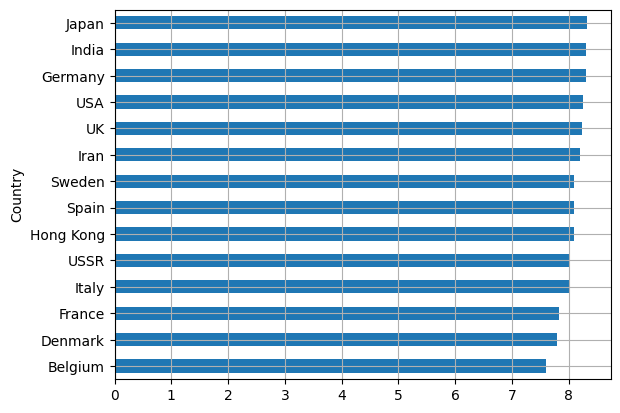

In [ ]:
df.groupby(by = 'Country')['IMDB Ratings'].mean().sort_values().plot.barh(
    grid = True
)

#### Outliers

The new observation that we have just appended is quite distinct compared to the overall observations in the data.  
In technical terms, it is an **outlier**.

> An outlier is an observation that lies outside the overall pattern of a distribution.

![](https://cdn.shortpixel.ai/client/q_glossy,ret_img,w_1667,h_1042/http://141.89.112.21/wp-content/uploads/2017/02/corrcoefs_1.png)

Although, mean is a very handy metric, it has a big disadvantage.
It is highly susceptible to the influence of outliers.

#### Skewed Distributions

> The mean loses its representativeness for the best central location of the data because the skewed data is dragging it away from the typical value.

![](https://schoolbag.info/physics/physics_math/physics_math.files/image790.jpg)



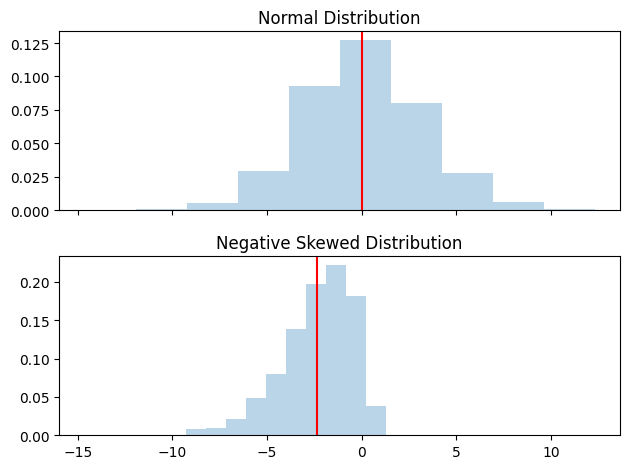

In [ ]:
from scipy.stats import skewnorm, norm

# number of instances
n = 1000
# mean
m = 0
# std
s = 3

# normal dist
r_norm = norm.rvs(loc=m, scale=s, size=n)
# skewed dist
skewness = -5 # skewness
r_skew = skewnorm.rvs(skewness, loc=m, scale=s, size=n)

fig, axes = plt.subplots(2,1, sharex=True)
# plot the normal and its mean
axes[0].set_title("Normal Distribution")
axes[0].hist(r_norm, alpha=0.3, density=True)
axes[0].axvline(r_norm.mean(), 0, 1, c="r")

# plot the skewed and it mean
axes[1].set_title("Negative Skewed Distribution")
axes[1].hist(r_skew, alpha=0.3, density=True)
axes[1].axvline(r_skew.mean(), 0, 1, c="r")

plt.tight_layout()
plt.show()

In case of outliers or skewed distribution, mean becomes a misleading measurement.

We can also check the skewness of distributions present in our dataset. Below, you can find distributions of `IMDB Ratings` and `Rotten Tomatoes Ratings`.

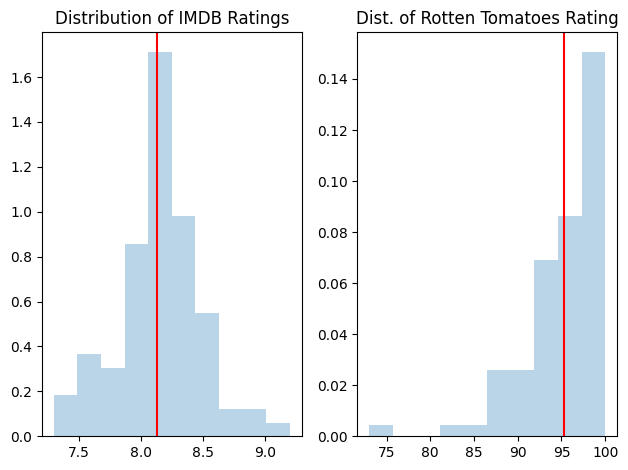

In [ ]:
# alternative
# checking movie rating distributions

fig, axes = plt.subplots(1, 2)
# plot IMDB Ratings distribution and its mean
axes[0].set_title("Distribution of IMDB Ratings")
axes[0].hist(df['IMDB Ratings'], alpha=0.3, density=True)
axes[0].axvline(df['IMDB Ratings'].mean(), 0, 1, c="r")

# plot Rotten Tomatoes Ratings distribution and its mean
axes[1].set_title("Dist. of Rotten Tomatoes Rating")
axes[1].hist(df['Rotten Tomatoes Ratings'], alpha=0.3, density=True)
axes[1].axvline(df['Rotten Tomatoes Ratings'].mean(), 0, 1, c="r")

plt.tight_layout()
plt.show()

Although it seems difficult to comment on the distribution of `IMDB Ratings`, distribution of `Rotten Tomatoes Ratings` seem negative skewed. In that case we can argue that movies with higher ratings in our dataset are causing mean value of `Rotten Tomatoes Ratings` to be higher than majority of movie reviews.

### Median

> The median is the `middle` value in a **sorted** list of numbers.

In [ ]:
df["IMDB Ratings"].median()

8.1

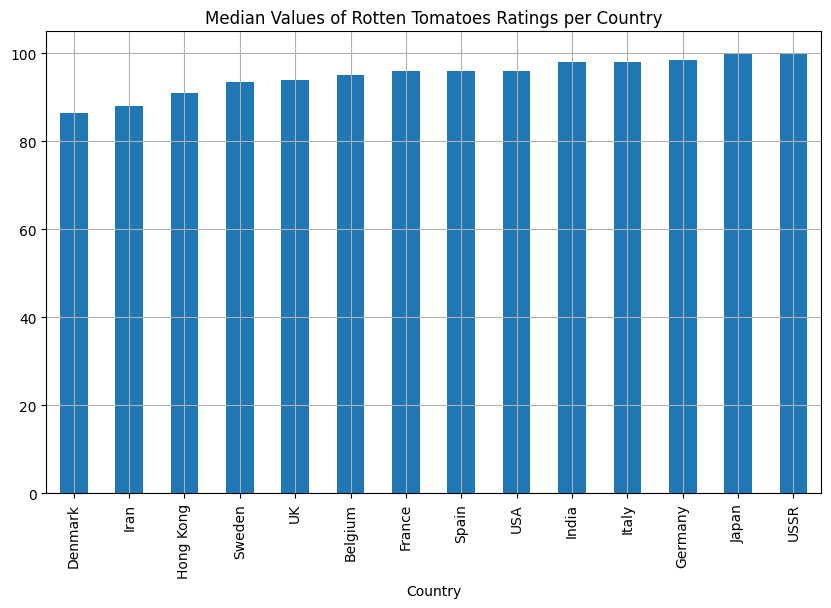

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = df.groupby(by = "Country").median()['Rotten Tomatoes Ratings'].sort_values().plot.bar()

plt.title("Median Values of Rotten Tomatoes Ratings per Country")
plt.grid()
plt.show()

Now, let's use the same setting above and observe how median behaves with rating distributions that we have.

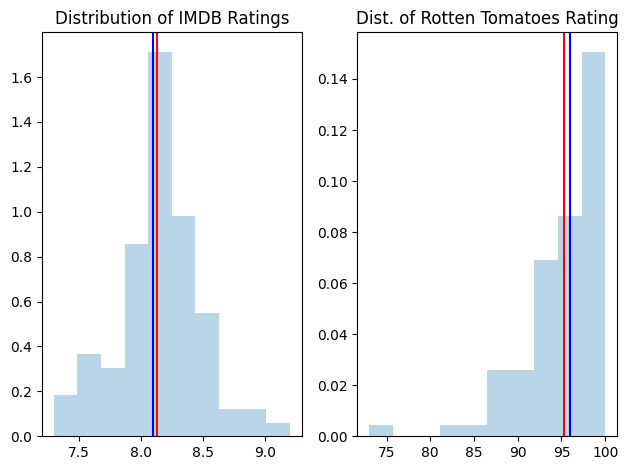

In [ ]:
fig, axes = plt.subplots(1, 2)
# plot IMDB Ratings distribution, its mean, and median
axes[0].set_title("Distribution of IMDB Ratings")
axes[0].hist(df['IMDB Ratings'], alpha=0.3, density=True)
axes[0].axvline(df['IMDB Ratings'].mean(), 0, 1, c="r")
axes[0].axvline(df['IMDB Ratings'].median(), 0, 1, c="b")

# plot Rotten Tomatoes Ratings distribution, its mean, and median
axes[1].set_title("Dist. of Rotten Tomatoes Rating")
axes[1].hist(df['Rotten Tomatoes Ratings'], alpha=0.3, density=True)
axes[1].axvline(df['Rotten Tomatoes Ratings'].mean(), 0, 1, c="r")
axes[1].axvline(df['Rotten Tomatoes Ratings'].median(), 0, 1, c="b")

plt.tight_layout()
plt.show()

### Mode

> The mode is the most frequent value in the data.

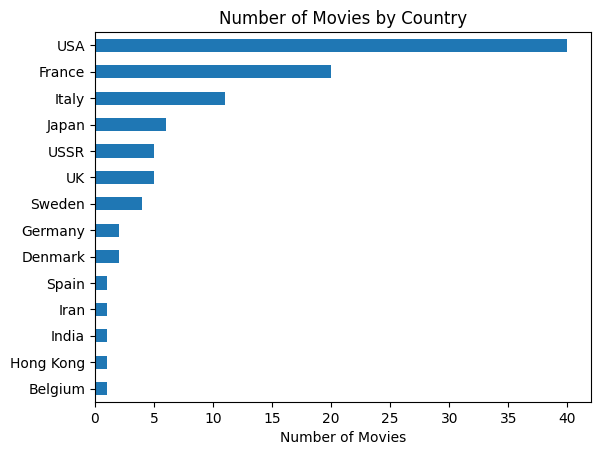

In [ ]:
from scipy import

ax = df["Country"].value_counts(ascending=True).plot.barh()
ax.set_title("Number of Movies by Country")
ax.set_xlabel("Number of Movies");

## Measures of Spreadness

> Measures of spread describe how similar or varied the set of observed values are for a particular variable.

### Variance & Standard Deviation

> Informally, it measures how far a set of numbers are spread out from their average value.

In [ ]:
print(f"Std: {df['IMDB Ratings'].std()}, Var: {df['IMDB Ratings'].var()}")

Std: 0.3500478763424714, Var: 0.12253351573187415


> Variance and standard deviation are almost the exact same thing! Variance is just the square of the standard deviation. Likewise, variance and standard deviation represent the same thing — a measure of spread — but it’s worth noting that the units are different. Whatever units your data are in, standard deviation will be the same, and variation will be in that units-squared.

## Bivariate Analysis



### Covariance

> The covariance is a measure for how two variables are related to each other, i.e., how two variables vary with each other.

$\Large{cov(X,Y) \; = \; \Sigma_{i=1}^N\frac{(x_i - \hat{x})(y_i - \hat{y})}{N}}$


In [ ]:
# returns a dataframe that stores the covariance values
df[["IMDB Ratings", "Rotten Tomatoes Ratings"]].cov()

,IMDB Ratings,Rotten Tomatoes Ratings
IMDB Ratings,0.122534,0.584268
Rotten Tomatoes Ratings,0.584268,21.309439


### Correlation

> Measures the linear correlation between two features and is closely related to the covariance. In fact, it’s a normalized version of the covariance. By dividing the covariance by the features’ standard deviations, we ensure that the correlation between two features is in the range [-1, 1], which makes it more interpretable than the unbounded covariance.

$\Large{Corr(X,Y) \; = \; \frac{cov(X,Y)}{\sigma_x \sigma_y}}$

In [ ]:
# by default performs pearson correlation
# you can apply other correlation methods
# with `method` optional method
# again returns a dataframe that stores the coefficients
df[["IMDB Ratings", "Rotten Tomatoes Ratings"]].corr()

,IMDB Ratings,Rotten Tomatoes Ratings
IMDB Ratings,1.000000,0.361575
Rotten Tomatoes Ratings,0.361575,1.000000


## Visualization

### Histograms

> A frequency distribution shows how often each different value in a set of data occurs. It is the most commonly used graph to show frequency distributions.

![](https://codingwithmax.com/wp-content/uploads/2019/12/histogram-example-daily-steps-taken-annotated.png)

#### Bin Size

To construct a histogram from a continuous variable you first need to split the data into intervals, called **bins**.

*How are we going to decide on the bin size?*

There is no right or wrong answer as to how wide a bin should be, but there are rules of thumb. You need to make sure that the bins are not too small or too large.

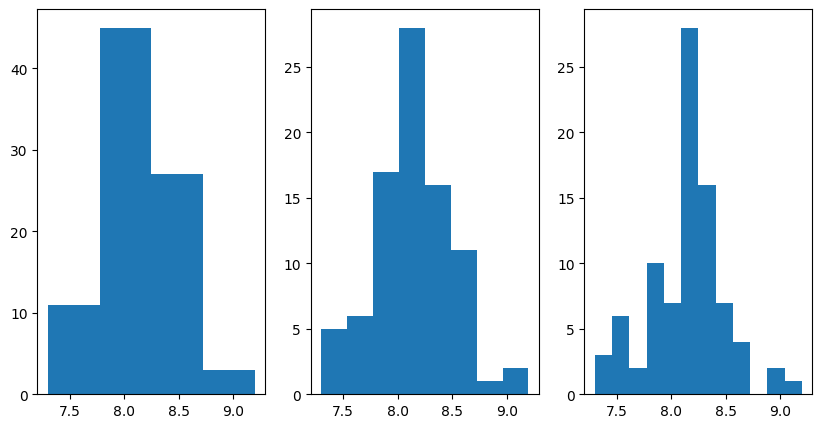

In [ ]:
data = df['IMDB Ratings'].values

_, axes = plt.subplots(1,3,figsize=(10,5))
axes[0].hist(data, bins=4)
axes[1].hist(data, bins=8)
axes[2].hist(data, bins=12)

plt.show()

Instead of manual inspection, you may apply bin size estimation methods.

**Scott’s rule** is based on the standard deviation of the data.

You may check this [link](https://docs.astropy.org/en/stable/visualization/histogram.html) for further details.

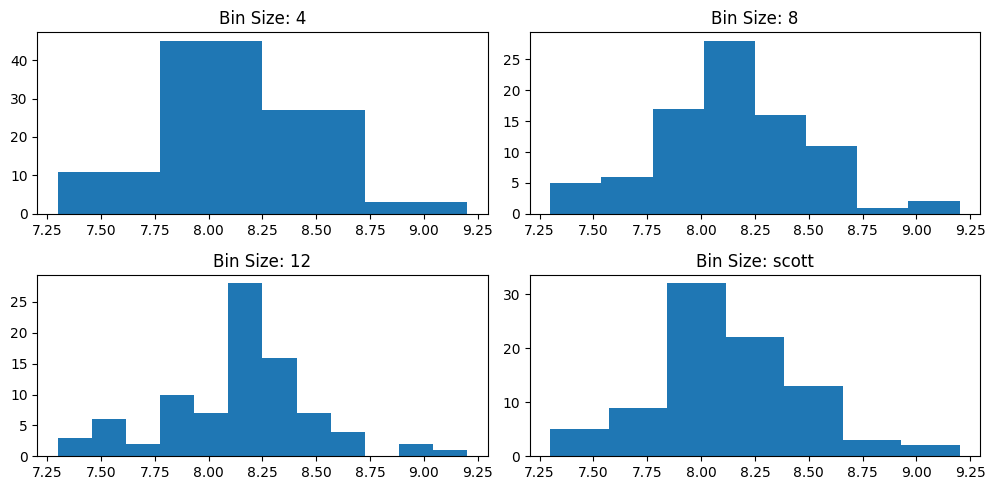

In [ ]:
data = df['IMDB Ratings'].values

n_rows = 2
n_cols = 2
bins = [4, 8, 12, "scott"]
_, axes = plt.subplots(n_rows, n_cols, figsize=(10,5))

for i, b in enumerate(bins):
  axes[i//2][i%2].hist(data, bins=b)
  axes[i//2][i%2].set_title(f"Bin Size: {b}")

plt.tight_layout()
plt.show()

And you can always define your own bins.

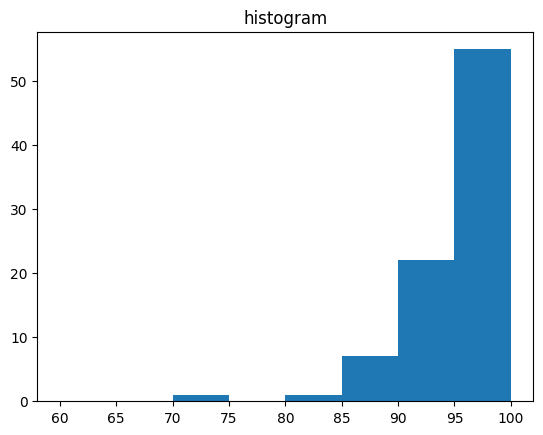

In [ ]:
rot_ratings = df['Rotten Tomatoes Ratings'].values
plt.hist(rot_ratings, bins = [60,65,70,75,80,85,90,95,100])
plt.title("histogram")
plt.show()

### Boxplots

![](https://miro.medium.com/max/18000/1*2c21SkzJMf3frPXPAR_gZA.png)

#### Quartile & Percentile

**Quartile**:

Quartiles divide a rank-ordered data set into four equal parts. The values that divide each part are called the first, second, and third quartiles; and they are denoted by Q1, Q2, and Q3, respectively.

Note the relationship between quartiles and percentiles. Q1 corresponds to P25, Q2 corresponds to P50, Q3 corresponds to P75. Q2 is the median value in a set of data.

---

**Percentile**:

Assume that the elements in a data set are rank ordered from the smallest to the largest. The values that divide a rank-ordered set of elements into 100 equal parts are called percentiles.

An element having a percentile rank of Pi would have a greater value than i percent of all the elements in the set. Thus, the observation at the 50th percentile would be denoted P50, and it would be greater than 50 percent of the observations in the set. An observation at the 50th percentile would correspond to the median value in the set.

[source](https://stattrek.com/descriptive-statistics/measures-of-position.aspx)


#### Exercise

In this exercise, you will first categorize the movie durations into three different categories:

- Less than 2 Hours
- 2-2.30 Hours
- and More than 2.30

Once you are done with the categorization, display the Rotten Tomatoes ratigns as boxplots per duration category. The resulting chart should look like the one below.

*Bonus: Try to sort the boxes with respect to their median values.*

![](https://i.ibb.co/SKt6Zb7/qs.png)

In [ ]:
# solution

def categorize_duration(duration):
  if duration < 120:
    return 'Less than 2 Hours'
  elif 120 <= duration <= 150:
    return '2 - 2.30 Hours'
  else:
    return 'More than 2.30'

df['Duration Category'] = df['Mins'].astype(int).apply(categorize_duration)

duration_groups = df.groupby(by = 'Duration Category')

value_dict = {}
for key, vals in duration_groups.groups.items():
  value_dict[key] = df.loc[vals]['Rotten Tomatoes Ratings'].dropna().values
  # you may also extract the values with out dropping NAs
  # in that case, you need to discard the NAs manually before providing to a function.
  # In the cell below, the commented lines are for that scenario
  #
  #value_dict[key] = df.loc[vals]['Rotten Tomatoes Ratings'].values
  #

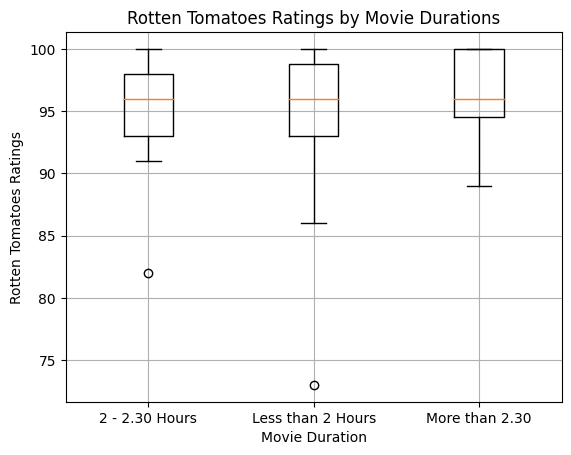

In [ ]:
ratings = sorted(value_dict.items(), key=lambda x: np.median(x[1]))
#ratings = sorted(value_dict.items(), key=lambda x: np.nanmedian(x[1]))

fig, ax = plt.subplots()

ax.boxplot([val[1] for val in ratings])
#ax.boxplot([[val for val in rating[1] if ~np.isnan(val)] for rating in ratings])
ax.set_xticklabels([rating[0] for rating in ratings])
ax.set_ylabel('Rotten Tomatoes Ratings')
ax.set_xlabel('Movie Duration')
ax.set_title('Rotten Tomatoes Ratings by Movie Durations')
ax.grid();

### Bivariate Analysis

![](https://www.i2tutorials.com/wp-content/uploads/2019/09/What-do-you-mean-by-Univariate-Bivariate-and-Multivariate-3-i2tutorials.png)



#### Heatmaps

In order to display the correlations among variables in the data, you may also deploy a heatmap.

![](https://miro.medium.com/max/3896/1*ALUzKhbL6_NLVHqhSUQDOg.png)

In [ ]:
df.head()

,﻿Pos,2020,Title,Director,Year,Country,Mins,IMDB Ratings,Rotten Tomatoes Ratings,Duration Category
0,1,1,Citizen Kane,"Welles, Orson",1941,USA,119,8.3,99.0,Less than 2 Hours
1,2,2,Vertigo,"Hitchcock, Alfred",1958,USA,128,8.3,94.0,2 - 2.30 Hours
2,3,3,2001: A Space Odyssey,"Kubrick, Stanley",1968,UK,139,8.3,92.0,2 - 2.30 Hours
3,4,4,The Rules of the Game,"Renoir, Jean",1939,France,113,8.0,96.0,Less than 2 Hours
4,5,5,Tokyo Story,"Ozu, Yasujiro",1953,Japan,134,8.2,100.0,2 - 2.30 Hours


In order to compute the correlation among the variables in a dataframe, we can directly call the `corr` method which returns another dataframe that stores the correlation coefficients.

However, before calling the method, we can still perform operations that will enrich our correlation study on the movie ratings dataset. By creating a new column that displays movie age, we can add the movie age information to correlation calculations. In addition to that, if we convert `Mins` column to integer values, we can also see whether movie length is correlated with ratings.

In [ ]:
# creating a new column called Movie Age
df['Movie Age'] = df['Year'].apply(lambda x : 2023 - int(x))
# also converting Mins column to integer to add it to correlation calculations
df['Mins'] = df['Mins'].astype(int)

df.head()

,﻿Pos,2020,Title,Director,Year,Country,Mins,IMDB Ratings,Rotten Tomatoes Ratings,Duration Category,Movie Age
0,1,1,Citizen Kane,"Welles, Orson",1941,USA,119,8.3,99.0,Less than 2 Hours,79
1,2,2,Vertigo,"Hitchcock, Alfred",1958,USA,128,8.3,94.0,2 - 2.30 Hours,62
2,3,3,2001: A Space Odyssey,"Kubrick, Stanley",1968,UK,139,8.3,92.0,2 - 2.30 Hours,52
3,4,4,The Rules of the Game,"Renoir, Jean",1939,France,113,8.0,96.0,Less than 2 Hours,81
4,5,5,Tokyo Story,"Ozu, Yasujiro",1953,Japan,134,8.2,100.0,2 - 2.30 Hours,67


In [ ]:
corrs = df.corr()
corrs

,Mins,IMDB Ratings,Rotten Tomatoes Ratings,Movie Age
Mins,1.000000,0.311205,0.063816,-0.350432
IMDB Ratings,0.311205,1.000000,0.343777,-0.027287
Rotten Tomatoes Ratings,0.063816,0.343777,1.000000,0.323587
Movie Age,-0.350432,-0.027287,0.323587,1.000000


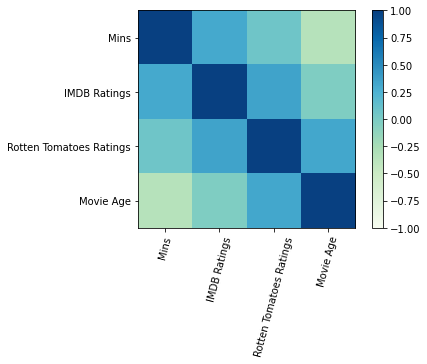

In [ ]:
plt.imshow(corrs, cmap="GnBu", vmin = -1, vmax = 1)
plt.colorbar()
plt.xticks(range(len(corrs)),corrs.columns, rotation=75)
plt.yticks(range(len(corrs)),corrs.index)
plt.show()